In [1]:
# -*- coding: utf-8 -*-

import meep as mp
from meep.materials import fused_quartz
import numpy as np
import math
import matplotlib.pyplot as plt

resolution = 200  # pixels/μm

dpml = 1.0
sz = 10+2*dpml
cell_size = mp.Vector3(0,0,sz)
pml_layers = [mp.PML(dpml)]

wvl_min = 0.4
wvl_max = 0.8
fmin = 1/wvl_max
fmax = 1/wvl_min
fcen = 0.5*(fmax+fmin)
df = fmax-fmin
nfreq = 50

sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df), component=mp.Ex, center=mp.Vector3(0,0,-0.5*sz+dpml))]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=1,
                    resolution=resolution)

refl_fr = mp.FluxRegion(center=mp.Vector3(0,0,-0.25*sz))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

empty_flux = mp.get_fluxes(refl)
empty_data = sim.get_flux_data(refl)
sim.reset_meep()

geometry = [ mp.Block(mp.Vector3(mp.inf,mp.inf,0.5*sz), center=mp.Vector3(0,0,0.25*sz), material=fused_quartz) ]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    dimensions=1,
                    resolution=resolution)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
sim.load_minus_flux_data(refl, empty_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ex, mp.Vector3(), 1e-9))

refl_flux = mp.get_fluxes(refl)
R_meep = -1*np.divide(refl_flux,empty_flux)

-----------
Initializing structure...
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 200
time for set_epsilon = 0.00153399 s
-----------
field decay(t = 50.0025): 0.25018932773921454 / 0.25018932773921454 = 1.0
field decay(t = 100.0025): 4.358317201613301e-16 / 0.25018932773921454 = 1.742007639173244e-15
run 0 finished at t = 100.0025 (40001 timesteps)

Field time usage:
        connecting chunks: 0.000319719 s
            time stepping: 1.3083 s
            communicating: 0.475856 s
     Fourier transforming: 0.416269 s
          everything else: 0.920692 s

-----------
Initializing structure...
Working in 1D dimensions.
Computational cell is 0 x 0 x 12 with resolution 200
     block, center = (0,0,3)
          size (1e+20,1e+20,6)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00103307 s
lorentzian susceptibility: frequency=0.101049, gamma=0
lorentzian susceptibility: frequency=8.6

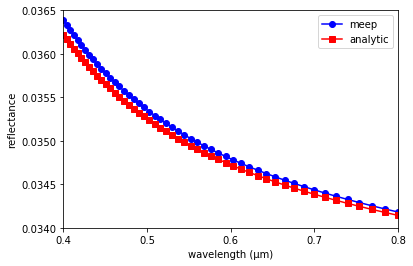

In [2]:
freqs = mp.get_flux_freqs(refl)
wvls = np.divide(1,freqs)

eps_quartz = lambda l: 1+0.6961663*math.pow(l,2)/(pow(l,2)-pow(0.0684043,2))+0.4079426*pow(l,2)/(pow(l,2)-pow(0.1162414,2))+0.8974794*pow(l,2)/(pow(l,2)-pow(9.896161,2))
R_fresnel = lambda l: math.pow(math.fabs(1-math.sqrt(eps_quartz(l)))/(1+math.sqrt(eps_quartz(l))),2)
R_analytic = [R_fresnel(i) for i in wvls]

plt.figure()
plt.plot(wvls,R_meep,'bo-',label='meep')
plt.plot(wvls,R_analytic,'rs-',label='analytic')
plt.xlabel("wavelength (μm)")
plt.ylabel("reflectance")
plt.axis([0.4, 0.8, 0.0340, 0.0365])
plt.xticks([t for t in np.arange(0.4,0.9,0.1)])
plt.legend(loc='upper right')
plt.show()